In [77]:
# Department of Computer Science, University at Buffalo

# Ramanathan Nachiappan : 50469166
# Akhil Krishnan Sunil:50468304
# Anirudh Muthusundaram:50471622

# A Deep Learning Based Approach for Exploring Cyberbullying in Social Media using Sentiment Analysis and Semantic Measures

#### Importing Necessary Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import unicodedata
# General purpose libraries

import tensorflow as tf
from tensorflow import keras

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from sklearn.feature_extraction.text import CountVectorizer
#   For preprocessing Data

from gensim.models import Word2Vec
from sklearn.feature_extraction.text import TfidfTransformer
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report
#metrics

import tensorflow as tf
from tensorflow import keras
#keras

import string # From some string manipulation tasks
import nltk # Natural language toolkit
from nltk.corpus import stopwords # Stop words in sentences
from nltk.stem import WordNetLemmatizer # For stemming the sentence
#NLP techniques

from keras.layers import Dense, Embedding, LSTM, SimpleRNN
from keras.models import Sequential
from sklearn.naive_bayes import MultinomialNB
from collections import Counter
from gensim.models import Word2Vec
import time
from sklearn.metrics.pairwise import cosine_similarity, pairwise_distances


#Models
from sklearn import svm
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#### DATA LOADING and CLEANING

In [2]:

dataev = pd.read_csv('cyberbullyingText.CSV')

In [3]:
dataev.head()

,textdata,bullyingtype
0,"In other words #katandandre, your food was cra...",NotCyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,NotCyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,NotCyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",NotCyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,NotCyberbullying


In [4]:
dataev.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47692 entries, 0 to 47691
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   textdata      47692 non-null  object
 1   bullyingtype  47692 non-null  object
dtypes: object(2)
memory usage: 745.3+ KB


#### Finding Duplicates

In [5]:
duplicatedrows = dataev.duplicated().sum()
print("The number of duplicated rows:", duplicatedrows)

The number of duplicated rows: 43


In [6]:
newdataframe = dataev.drop_duplicates()

#### Finding Value Distributions for The classes

In [7]:
newdataframe.groupby('bullyingtype').size()

bullyingtype
Age                    7990
Gender                 7945
NotCyberbullying       7937
Race                   7959
Religion               7997
other_cyberbullying    7821
dtype: int64

#### Removing Other Cyberbullying as it doesn't offer any advantage to the model and doesn't signify anything properly

In [8]:
newdataframe = newdataframe.query("bullyingtype != 'other_cyberbullying'")


In [9]:
newdataframe.groupby('bullyingtype').size()


bullyingtype
Age                 7990
Gender              7945
NotCyberbullying    7937
Race                7959
Religion            7997
dtype: int64

#### Vizualisation of Features

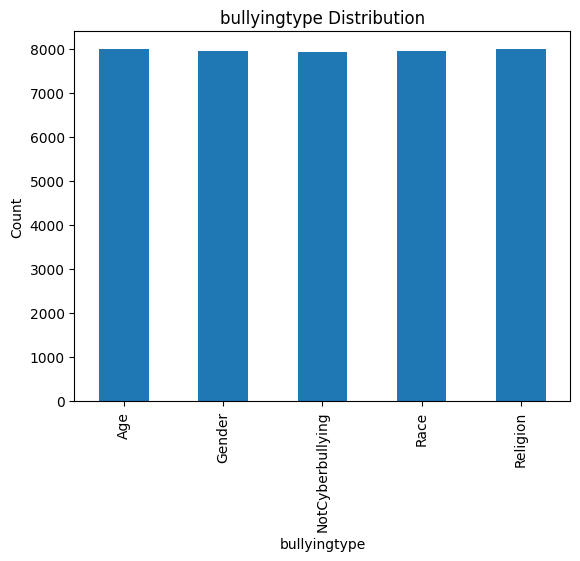

In [10]:
import matplotlib.pyplot as plt

newdataframe.groupby('bullyingtype').size().plot(kind='bar')

plt.xlabel('bullyingtype')
plt.ylabel('Count')
plt.title('bullyingtype Distribution')

plt.show()

<Axes: >

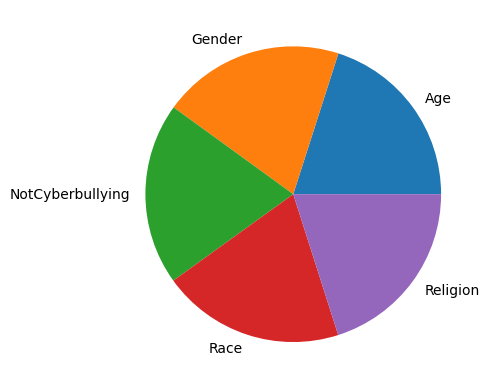

In [11]:
newdataframe.groupby('bullyingtype').size().plot(kind='pie')

#### Pre-Processing of social meida data

#### 1) Emoji Stripping

In [12]:
def emojistripping(input):
    emojicombinations = re.compile("["
                           u"\U0001F600-\U0001F64F"  
                           u"\U0001F300-\U0001F5FF"  
                           u"\U0001F680-\U0001F6FF"  
                           u"\U0001F1E0-\U0001F1FF"  
                           "]+", flags=re.UNICODE)
    return emojicombinations.sub(r'', input)


#### 2) Removal of newline characters

In [13]:
def remove_newline_characters(input):
    cleaned_text = ' '.join(input.splitlines())
    return cleaned_text

#### 3) Removal of mentions in the tweets

In [14]:
def remove_links_mentions(input):
    input = re.sub(r"(?:\@|https?\://)\S+", "", input)
    return input

#### 4) Removal of non ascii characters

In [15]:
def remove_non_ascii(input):
    cleaned_text = ''.join(char for char in input if unicodedata.category(char)[0] != 'C')
    return cleaned_text

#### 5) Removal of the punctuations

In [16]:
def remove_punctuations(input):
    cleaned_text = ''.join(char for char in input if char not in string.punctuation)
    return cleaned_text


#### 6) Removing Stopwords

In [17]:
def remove_stopwords(input):
    setstopwordlist = set(stopwords.words('english'))
    words = input.split()
    cleaned_words = [word for word in words if word.lower() not in setstopwordlist]
    cleaned_text = ' '.join(cleaned_words)
    return cleaned_text

#### 7) Removing words over 15 char in length

In [18]:
def remove_long_words(input, smaxlength=15):
    cleaned_words = []
    for word in input.split():
        if len(word) < smaxlength:
            cleaned_words.append(word)
    cleaned_text = ' '.join(cleaned_words)
    return cleaned_text

#### 8) Removal of hashtags 

In [19]:
def removethehashtags(input):
    
    input = re.sub(r'(?<!\bhashtag)#\w+', '', input)
    
    
    words = re.split(r'#[\w-]+|_', input)
    
    
    cleaned_text = ' '.join(word.strip() for word in words)
    
    return cleaned_text

#### 9) Removing Contracted word forms

In [20]:
def contractionremoval(input):
    contractiontypes = [
        (r"\'re", " are"),
        (r"\'ve", " have"),
        (r"\'s", " is"),
        (r"\'d", " would"),
        (r"\'ll", " will"),
        (r"n\'t", " not"),
        (r"\'m", " am")
    ]
    for contractiontype, changes in contractiontypes:
        input = re.sub(contractiontype, changes, input)
    return input

#### 10) Trailing Space Removal

In [21]:
def adjspaceremoval(input):
    cleaned_text = ' '.join(input.split())
    return cleaned_text

#### 11) Stemming of words

In [22]:
from nltk.stem import SnowballStemmer

def stem_text(input):
    tokenizesocialdata = nltk.word_tokenize(input)
    stemmer = SnowballStemmer("english")
    return ' '.join([stemmer.stem(word) for word in tokenizesocialdata])

#### 12) Driver Function to preprocess the text

In [23]:
def preprocess(input):
    input = emojistripping(input)
    input = contractionremoval(input)
    input = remove_newline_characters(input)
    input = remove_links_mentions(input)
    input = remove_non_ascii(input)
    input = remove_punctuations(input)
    input = remove_stopwords(input)
    input = remove_long_words(input, smaxlength=15)
    input = removethehashtags(input)
    input = adjspaceremoval(input)
    input = stem_text(input)
    return input

#### Create a new preprocessedtext df record

In [24]:
preprocessedtexts = [preprocess(t) for t in newdataframe.textdata]

#### Vizualing preprocessed data

In [25]:
preprocessedtexts

['word katandandr food crapilici mkr',
 'aussietv white mkr theblock imacelebrityau today sunris studio10 neighbour wonderlandten etc',
 'classi whore red velvet cupcak',
 'meh p thank head concern anoth angri dude twitter',
 'isi account pretend kurdish account like islam lie',
 'yes test god good bad indiffer weird whatev prove god exist',
 'itu sekolah ya bukan tempat bulli ga jauh kaya neraka',
 'karma hope bite kat butt nasti mkr',
 'everyth most priest',
 'rebecca black drop school due bulli',
 '',
 'bulli flush kd',
 'ughhhh mkr',
 'rt turkish state kill 241 children last 11 year news',
 'love best respons hotcak manag film noncommitt meh adolesc mkr',
 'parem de fazer bulli comigo uhahuah bando de preto',
 'tadinhu de mim sofrendo bull viu mimi',
 'twitter basic angri letter generat',
 'best pick line hi cute love peopl call jame potter bulli',
 'got ta walk classss offici hate stupid bus system',
 'know saudi chase girl burn build',
 'kid love❤ mohamad bin zay citi مدينة محمد 

#### Using the Preprocessor function to improve on the performance of the manual pre-processing

In [26]:
import preprocessor as process

def preprocess_tweet(text):
    return process.clean(text)

newdataframe['PreProcessedText'] = newdataframe['textdata'].apply(preprocess_tweet)
newdataframe.head()


,textdata,bullyingtype,PreProcessedText
0,"In other words #katandandre, your food was cra...",NotCyberbullying,"In other words , your food was crapilicious!"
1,Why is #aussietv so white? #MKR #theblock #ImA...,NotCyberbullying,Why is so white?
2,@XochitlSuckkks a classy whore? Or more red ve...,NotCyberbullying,a classy whore? Or more red velvet cupcakes?
3,"@Jason_Gio meh. :P thanks for the heads up, b...",NotCyberbullying,"meh. thanks for the heads up, but not too conc..."
4,@RudhoeEnglish This is an ISIS account pretend...,NotCyberbullying,This is an ISIS account pretending to be a Kur...


#### Lemmatization of the preprocessed data

In [27]:
def lemm_text(input):
    tokenizesocialdata = nltk.word_tokenize(input)
    lemmatizer = WordNetLemmatizer()
    return ' '.join([lemmatizer.lemmatize(words) for words in tokenizesocialdata])

In [28]:
def preprocess(input):
    text = lemm_text(input)
    return text

In [29]:
finalpreprocessed = [preprocess(t) for t in newdataframe.PreProcessedText]

In [30]:
newdataframe['PreProcessedText'] = finalpreprocessed
newdataframe.head()

,textdata,bullyingtype,PreProcessedText
0,"In other words #katandandre, your food was cra...",NotCyberbullying,"In other word , your food wa crapilicious !"
1,Why is #aussietv so white? #MKR #theblock #ImA...,NotCyberbullying,Why is so white ?
2,@XochitlSuckkks a classy whore? Or more red ve...,NotCyberbullying,a classy whore ? Or more red velvet cupcake ?
3,"@Jason_Gio meh. :P thanks for the heads up, b...",NotCyberbullying,"meh . thanks for the head up , but not too con..."
4,@RudhoeEnglish This is an ISIS account pretend...,NotCyberbullying,This is an ISIS account pretending to be a Kur...


#### Removing the duplicates in textdata after preprocessing

In [31]:
clean_text_duplicates = newdataframe[newdataframe.duplicated("PreProcessedText")]
newdataframe.drop_duplicates("PreProcessedText", inplace=True)
finval = newdataframe["bullyingtype"].value_counts()

print("Number of content duplicates:", len(clean_text_duplicates))
print("Value counts per sentiment:")
print(finval)

Number of content duplicates: 683
Value counts per sentiment:
Religion            7962
Age                 7957
Race                7870
NotCyberbullying    7725
Gender              7631
Name: bullyingtype, dtype: int64


#### Reducing data to lower case

In [32]:
newdataframe['PreProcessedText'] = newdataframe['PreProcessedText'].apply(lambda x: x.lower())
newdataframe.head()


,textdata,bullyingtype,PreProcessedText
0,"In other words #katandandre, your food was cra...",NotCyberbullying,"in other word , your food wa crapilicious !"
1,Why is #aussietv so white? #MKR #theblock #ImA...,NotCyberbullying,why is so white ?
2,@XochitlSuckkks a classy whore? Or more red ve...,NotCyberbullying,a classy whore ? or more red velvet cupcake ?
3,"@Jason_Gio meh. :P thanks for the heads up, b...",NotCyberbullying,"meh . thanks for the head up , but not too con..."
4,@RudhoeEnglish This is an ISIS account pretend...,NotCyberbullying,this is an isis account pretending to be a kur...


#### Removing content with less than 9 words and greater than 46 words

In [33]:
newdataframe['textdatacountsize'] = newdataframe['PreProcessedText'].apply(lambda text: len(text.split()))

newdataframe = newdataframe[(newdataframe['textdatacountsize'] > 9) & (newdataframe['textdatacountsize'] < 46)]

totlen = np.max(newdataframe['textdatacountsize'])
totlen


45

In [34]:
newdataframe.head()

,textdata,bullyingtype,PreProcessedText,textdatacountsize
2,@XochitlSuckkks a classy whore? Or more red ve...,NotCyberbullying,a classy whore ? or more red velvet cupcake ?,10
3,"@Jason_Gio meh. :P thanks for the heads up, b...",NotCyberbullying,"meh . thanks for the head up , but not too con...",19
4,@RudhoeEnglish This is an ISIS account pretend...,NotCyberbullying,this is an isis account pretending to be a kur...,20
5,"@Raja5aab @Quickieleaks Yes, the test of god i...",NotCyberbullying,"yes , the test of god is that good or bad or i...",24
6,Itu sekolah ya bukan tempat bully! Ga jauh kay...,NotCyberbullying,itu sekolah ya bukan tempat bully ! ga jauh ka...,11


#### STEPS FOR COMPUTING SEMANTIC SIMILARITY

#### REMOVE HASHTAGS AND RUN THE CODE FOR COMPUTING SEMANTIC SIMILARITY (REQUIRES HIGHER POWERED SYSTEM WITH MORE THAN 16 GB OF RAM)

In [79]:
#vectorizer = TfidfVectorizer()
#tfidf  = vectorizer.fit_transform(data['PreProcessedText'])

In [36]:
# Dimensionality reduction using truncated SVD
#from sklearn.decomposition import TruncatedSVD
#svd = TruncatedSVD(n_components=1000)
#svd.fit(tfidf)
#tfidf_svd = svd.transform(tfidf)

In [37]:
# Calculation of sematic Similarity
#cosine_sim = cosine_similarity(tfidf)
#pearson_sim = 1 - pairwise_distances(np.asarray(tfidf.todense()), metric="correlation")

In [38]:
#X = np.hstack([tfidf.toarray(), cosine_sim, pearson_sim])
#y = data['bullyingtype']
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Train Test splitting of the data

In [39]:
X_train, X_test, y_train, y_test = train_test_split(newdataframe['PreProcessedText'], newdataframe['bullyingtype'], test_size=0.2, random_state=32)

#### Vectorization using TF-IDF

In [40]:
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

#### setting the class names

In [41]:
sentiment = ["Religion","Age","Gender","Race","NotCyberbullying"]

BASELINE MODELS FIRST TESTED WITH THE DATASET

In [46]:
# SVM Model
svm_model = svm.SVC(kernel='linear')
svm_model.fit(X_train, y_train)

y_pred_svm = svm_model.predict(X_test)

print("SVM Classification Report:")
print(classification_report(y_test, y_pred_svm,target_names=sentiment))
print("SVM Accuracy:", accuracy_score(y_test, y_pred_svm)*100)

SVM Classification Report:
                  precision    recall  f1-score   support

        Religion       0.96      0.97      0.97      1011
             Age       0.93      0.87      0.90      1153
          Gender       0.77      0.84      0.81      1043
            Race       0.98      0.99      0.98      1166
NotCyberbullying       0.95      0.91      0.93       966

        accuracy                           0.92      5339
       macro avg       0.92      0.92      0.92      5339
    weighted avg       0.92      0.92      0.92      5339

SVM Accuracy: 87.04626334519574


In [43]:
# Bagging of Decision tree

bagging_dt = BaggingClassifier(DecisionTreeClassifier(max_depth=10), n_estimators=100)
bagging_dt.fit(X_train, y_train)

y_pred_bagging_dt = bagging_dt.predict(X_test)

print("Bagging of Decision Trees Classification Report:")
print(classification_report(y_test, y_pred_bagging_dt,target_names=sentiment))
print("Bagging of Decision Trees Accuracy:", accuracy_score(y_test, y_pred_bagging_dt)*100)

Bagging of Decision Trees Classification Report:
                  precision    recall  f1-score   support

        Religion       0.99      0.93      0.96      1011
             Age       0.97      0.71      0.82      1153
          Gender       0.52      0.96      0.68      1043
            Race       0.97      0.91      0.94      1166
NotCyberbullying       0.98      0.54      0.70       966

        accuracy                           0.81      5339
       macro avg       0.89      0.81      0.82      5339
    weighted avg       0.89      0.81      0.82      5339

Bagging of Decision Trees Accuracy: 77.24199288256229


In [44]:
# Naive Bayes

from sklearn.naive_bayes import MultinomialNB
nb_clf = MultinomialNB()
nb_clf.fit(X_train, y_train)

nb_pred = nb_clf.predict(X_test)
print('Classification Report for Naive Bayes:\n',classification_report(y_test, nb_pred, target_names=sentiment))
print("Naive Bayes Accuracy:", accuracy_score(y_test, nb_pred)*100)

Classification Report for Naive Bayes:
                   precision    recall  f1-score   support

        Religion       0.85      0.97      0.91      1011
             Age       0.79      0.90      0.84      1153
          Gender       0.87      0.47      0.61      1043
            Race       0.88      0.97      0.92      1166
NotCyberbullying       0.86      0.92      0.89       966

        accuracy                           0.85      5339
       macro avg       0.85      0.85      0.83      5339
    weighted avg       0.85      0.85      0.84      5339

Naive Bayes Accuracy: 80.4982206405694


In [47]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier()
rf_clf.fit(X_train, y_train)
rf_pred = rf_clf.predict(X_test)
print('Classification Report for Random Forest:\n',classification_report(y_test, rf_pred, target_names=sentiment))
print("Random Forest Accuracy:", accuracy_score(y_test, rf_pred)*100)

Classification Report for Random Forest:
                   precision    recall  f1-score   support

        Religion       0.97      0.97      0.97      1011
             Age       0.94      0.83      0.88      1153
          Gender       0.75      0.88      0.81      1043
            Race       0.98      0.98      0.98      1166
NotCyberbullying       0.95      0.90      0.93       966

        accuracy                           0.91      5339
       macro avg       0.92      0.91      0.91      5339
    weighted avg       0.92      0.91      0.91      5339

Random Forest Accuracy: 86.69039145907473


In [48]:
from sklearn.ensemble import GradientBoostingClassifier

# Gradient Boosting
gboost = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=10, random_state=42)
gboost.fit(X_train, y_train)

y_pred_gboost = gboost.predict(X_test)

print("Gradient Boosting Classification Report:")
print(classification_report(y_test, y_pred_gboost,target_names=sentiment))
print("Gradient Boosting Accuracy:", accuracy_score(y_test, y_pred_gboost)*100)

Gradient Boosting Classification Report:
                  precision    recall  f1-score   support

        Religion       0.99      0.97      0.98      1011
             Age       0.95      0.84      0.89      1153
          Gender       0.75      0.91      0.82      1043
            Race       0.99      0.99      0.99      1166
NotCyberbullying       0.95      0.90      0.93       966

        accuracy                           0.92      5339
       macro avg       0.93      0.92      0.92      5339
    weighted avg       0.93      0.92      0.92      5339

Gradient Boosting Accuracy: 86.35886870200413


#### Prediciton on user given data

In [49]:
new_text = ["you are a christian piece of shit"]
new_text = [preprocess(text) for text in new_text]
new_text = vectorizer.transform(new_text)

print("SVM Prediction:")
print(svm_model.predict(new_text))

print("Bagging Decision tree Prediction:")
print(bagging_dt.predict(new_text))

print("Naive Bayes Prediction:")
print(nb_clf.predict(new_text))

print("Random Forest Prediction:")
print(rf_clf.predict(new_text))

print("GradientBoosting Prediction:")
print(gboost.predict(new_text))

SVM Prediction:
['Religion']
Bagging Decision tree Prediction:
['Religion']
Naive Bayes Prediction:
['Religion']
Random Forest Prediction:
['NotCyberbullying']
GradientBoosting Prediction:
['Religion']


### LSTM-RNN IMPLEMENTATION

In [50]:
sentiment_mapping = {'Religion': 0, 'Age': 1, 'Race': 2, 'Gender': 3, 'NotCyberbullying': 4}
newdataframe['bullyingtype'] = newdataframe['bullyingtype'].map(sentiment_mapping)


#### Train test split before oversampling

In [51]:
X = newdataframe['PreProcessedText']
y = newdataframe['bullyingtype']

# Splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=32)

# Further splitting train set into train and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, stratify=y_train, random_state=32)

#### Oversampling using randomsampler

In [52]:
# Initialize RandomOverSampler
sampler = RandomOverSampler()

# Reshape X_train and y_train
X_train_reshaped = np.array(X_train).reshape(-1, 1)
y_train_reshaped = np.array(y_train).reshape(-1, 1)

# Apply random oversampling
X_train_resampled, y_train_resampled = sampler.fit_resample(X_train_reshaped, y_train_reshaped)

# Create a modified DataFrame
modified = pd.DataFrame(list(zip([x[0] for x in X_train_resampled], y_train_resampled)), columns=['PreProcessedText', 'bullyingtype'])


In [53]:
X_train = modified['PreProcessedText'].values
y_train = modified['bullyingtype'].values

#### TOKENIZATION OF DATA

In [54]:
def create_vocabulary(input_column):
    bag = [word for sentence in input_column for word in sentence.split()]
    word_counter = Counter(bag)
    sw = word_counter.most_common()
    intt = {word: i+1 for i, (word, count) in enumerate(sw)}
    return intt

def tokenize_text(input_column, intt):
    tokenized_texts = []
    for sentence in input_column:
        tokenized = [intt[word] for word in sentence.split()]
        tokenized_texts.append(tokenized)
    return tokenized_texts

def pad_sequences(tokenized_texts, smaxlen):
    padded_features = np.zeros((len(tokenized_texts), smaxlen), dtype=int)
    for i, tokenized in enumerate(tokenized_texts):
        if len(tokenized) <= smaxlen:
            padding = list(np.zeros(smaxlen - len(tokenized)))
            new_sequence = padding + tokenized
        else:
            new_sequence = tokenized[: smaxlen]
        padded_features[i, :] = np.array(new_sequence)
    return padded_features

def process_text(input_column, smaxlen):
    word_to_int = create_vocabulary(input_column)
    tokenized_texts = tokenize_text(input_column, word_to_int)
    padded_features = pad_sequences(tokenized_texts, smaxlen)
    return word_to_int, padded_features


In [55]:
lexis, tocol = process_text(newdataframe["PreProcessedText"], totlen)

In [56]:
trainforvec = [sentence.split() for sentence in X_train]

In [57]:
totdim = 150

In [58]:
w2vec = Word2Vec(trainforvec, vector_size=totdim)

In [59]:
totsize = len(lexis)+1 # for the padding

#### TRAIN TEST SPLIT

In [60]:
X = tocol
y = newdataframe['bullyingtype'].values

In [61]:
# Splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=32)

# Further splitting train set into train and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, stratify=y_train, random_state=32)

In [62]:
sampler = RandomOverSampler()
X_modified, y_modified = sampler.fit_resample(np.array(X_train),np.array(y_train));

#### TRAINING, TESTING AND VALIDATION DATA SETTING

In [63]:
tr = TensorDataset(torch.from_numpy(X_modified), torch.from_numpy(y_modified))
tsd = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))
validationd = TensorDataset(torch.from_numpy(X_valid), torch.from_numpy(y_valid))

#### Loading of the data using dataloader

In [64]:
ldtrain = DataLoader(tr, shuffle=True, batch_size=32, drop_last=True) 
ldvalid = DataLoader(validationd, shuffle=True, batch_size=32, drop_last=True)
ldtst = DataLoader(tsd, shuffle=True, batch_size=32, drop_last=True)

#### Parameters for the LSTM NN

In [65]:
Classes = 5 # Total Number of Classes
Drop = 0.5 #Dropout Value
Layers = 3 #Layer Numbers of the NN
epoch = 5 # Total Epoch for Training
LearningR = 2e-4 #
BIDIRECTIONAL = True #
Neuron = 100 # Total Neuraons

In [66]:
system = 'cuda' if torch.cuda.is_available() else 'cpu'

#### DEFINITION FOR THE NN LSTM MODEL

In [67]:
class LstmSentimentModel(nn.Module):

    def __init__(self, totsize, totdim, hsize, Nclass, ll, directmeasure, bs, lstmdp):
        super(LstmSentimentModel, self).__init__()
        self.Nclass = Nclass
        self.directions = 2 
        self.hsize = hsize
        self.ll = ll
        self.bs = bs

        self.embedding = nn.Embedding(totsize, totdim)
        self.lstm = nn.LSTM(totdim, hsize, bidirectional=directmeasure, num_layers=ll, dropout=lstmdp, batch_first=True)
        self.fc = nn.Linear(hsize * self.directions, Nclass)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, q, secret):
        self.bs = q.size(0)
        embed = self.embedding(q)
        output, secret = self.lstm(embed, secret)
        output = output[:, -1, :]
        output = self.fc(output)
        output = self.softmax(output)
        return output, secret

    def hid(self, bs):
        # Initialization of the LSTM hidden and cell states
        hidden_state_h = torch.zeros((self.ll * self.directions, bs, self.hsize)).detach().to(system)
        hidden_state_c = torch.zeros((self.ll * self.directions, bs, self.hsize)).detach().to(system)
        secret = (hidden_state_h, hidden_state_c)
        return secret


#### Creating EMb matrix

In [68]:
mateb = np.zeros((totsize, totdim))   
for givwd, tokindex in lexis.items():
    if w2vec.wv.__contains__(givwd):
        mateb[tokindex] = w2vec.wv.__getitem__(givwd)

print("Emb Mat Shape is :", mateb.shape)

Emb Mat Shape is : (28388, 150)


#### Defining the model with neuralnetlstm

In [69]:
neuralnetlstm = LstmSentimentModel(totsize, totdim, Neuron,Classes, Layers,True, 32, Drop)
neuralnetlstm = neuralnetlstm.to(system)
neuralnetlstm.embedding.weight.data.copy_(torch.from_numpy(mateb))
neuralnetlstm.embedding.weight.requires_grad=True
print(neuralnetlstm)

LstmSentimentModel(
  (embedding): Embedding(28388, 150)
  (lstm): LSTM(150, 100, num_layers=3, batch_first=True, dropout=0.5, bidirectional=True)
  (fc): Linear(in_features=200, out_features=5, bias=True)
  (softmax): LogSoftmax(dim=1)
)


#### setting ADAM OPTIMIZER

In [70]:
criterion = nn.NLLLoss()
optimizer = torch.optim.AdamW(neuralnetlstm.parameters(), lr=LearningR, weight_decay = 4e-6)

#### EVALUATION LOOP FOR THE LSTM RNN

In [71]:
esp = 3
esc = 0
vmax = 0

ST = len(ldtrain)
ST_val = len(ldvalid)

for k in range(epoch):
    train_target, validtrgt = [], []
    lstr, lossvl  = [], []
    act, acvd  = [], []
    
    c, c_val = 0, 0
    t, t_val = 0, 0
    rl, rl_val = 0, 0

    neuralnetlstm.train()

    for i, l in ldtrain:
        i, l = i.to(system), l.to(system)
        h = neuralnetlstm.hid(l.size(0))

        neuralnetlstm.zero_grad() 
        op, h = neuralnetlstm(i,h) 
        totlss = criterion(op, l)
        totlss.backward()
        rl += totlss.item()
        optimizer.step()

        trainprdy = torch.argmax(op, dim=1) 
        train_target.extend(trainprdy.squeeze().tolist()) 
        
        c += torch.sum(trainprdy==l).item() 
        t += l.size(0) 

    lstr.append(rl / ST)
    act.append(100 * c / t)    
    with torch.no_grad():
        
        neuralnetlstm.eval()
        
        for i, l in ldvalid:
            i, l = i.to(system), l.to(system)

            hidv = neuralnetlstm.hid(l.size(0))

            modelop,hidv = neuralnetlstm(i,hidv)

            totvl = criterion(modelop, l)
            rl_val += totvl.item()

            predictvaly = torch.argmax(modelop, dim=1)
            validtrgt.extend(predictvaly.squeeze().tolist())

            c_val += torch.sum(predictvaly==l).item()
            t_val += l.size(0)

        lossvl.append(rl_val / ST_val)
        acvd.append(100 * c_val / t_val)

    #Saving the model for future use
    if np.mean(acvd) >= vmax:
        torch.save(neuralnetlstm.state_dict(), './LSTM.pt')
        print(f'Epoch Number {k+1} : Improvement detected ({vmax:.4f} to {np.mean(acvd):.4f}). Writing to Disc')
        vmax = np.mean(acvd)
        esc=0
    else:
        print(f'Epoch Number {k+1} : No improvement in validation accuracy')
        esc+=1
        
    if esc > esp:
        break
        
    print(f'\tTraining Accuracy Achieved : {np.mean(act):.2f}% Validation Accuracy Achieved : {np.mean(acvd):.2f}%')
    print(f'\tTraining Loss Incurred : {np.mean(lstr):.2f} Validation Loss Incurred : {np.mean(lossvl):.2f}')
    

Epoch Number 1 : Improvement detected (0.0000 to 86.6477). Writing to Disc
	Training Accuracy Achieved : 78.20% Validation Accuracy Achieved : 86.65%
	Training Loss Incurred : 0.58 Validation Loss Incurred : 0.35
Epoch Number 2 : Improvement detected (86.6477 to 88.5417). Writing to Disc
	Training Accuracy Achieved : 88.65% Validation Accuracy Achieved : 88.54%
	Training Loss Incurred : 0.31 Validation Loss Incurred : 0.31
Epoch Number 3 : Improvement detected (88.5417 to 89.1098). Writing to Disc
	Training Accuracy Achieved : 90.19% Validation Accuracy Achieved : 89.11%
	Training Loss Incurred : 0.27 Validation Loss Incurred : 0.29
Epoch Number 4 : Improvement detected (89.1098 to 90.0095). Writing to Disc
	Training Accuracy Achieved : 91.46% Validation Accuracy Achieved : 90.01%
	Training Loss Incurred : 0.23 Validation Loss Incurred : 0.27
Epoch Number 5 : Improvement detected (90.0095 to 90.2936). Writing to Disc
	Training Accuracy Achieved : 92.87% Validation Accuracy Achieved : 9

#### SAVING THE LSTM MODEL FILE

In [72]:
neuralnetlstm.load_state_dict(torch.load('./LSTM.pt'))

<All keys matched successfully>

#### EVALUATION LOOP

In [73]:
neuralnetlstm.eval()
predictions = []
actual_labels = []
for data, targets in ldtst:
    data, targets = data.to(system), targets.to(system)
    hidden = neuralnetlstm.hid(targets.size(0))

    result, h = neuralnetlstm(data, hidden)
    preds = torch.argmax(result, dim=1)
    predictions.extend(preds.squeeze().tolist())
    actual_labels.extend(targets.squeeze().tolist())

#### CLASSIFICATION REPORT FOR LSTM

In [74]:
print('Classification Report for Bidirectional-LSTM :\n', classification_report(actual_labels,  predictions, target_names=sentiment))

Classification Report for Bidirectional-LSTM :
                   precision    recall  f1-score   support

        Religion       0.91      0.95      0.92       932
             Age       0.98      0.95      0.97       989
          Gender       0.98      0.97      0.98      1170
            Race       0.83      0.92      0.87      1153
NotCyberbullying       0.82      0.73      0.77      1068

        accuracy                           0.90      5312
       macro avg       0.90      0.90      0.90      5312
    weighted avg       0.90      0.90      0.90      5312



In [75]:
print("LSTM Accuracy:", accuracy_score(actual_labels,  predictions)*100)

LSTM Accuracy: 90.32379518072288


#### WORD CLOUD IMPLEMENTATION

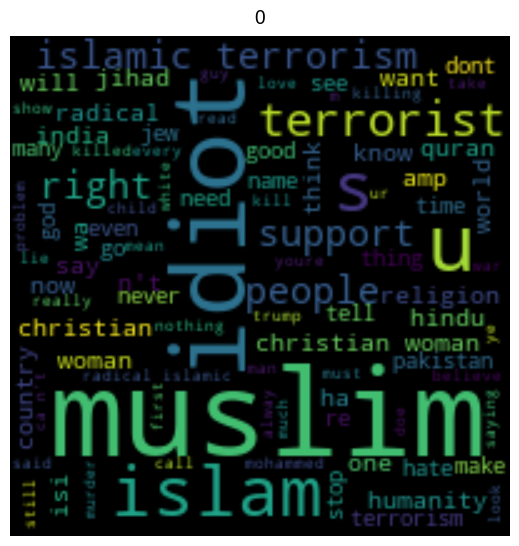

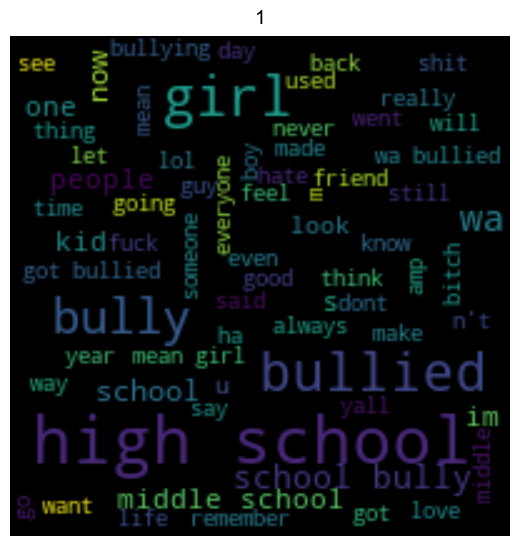

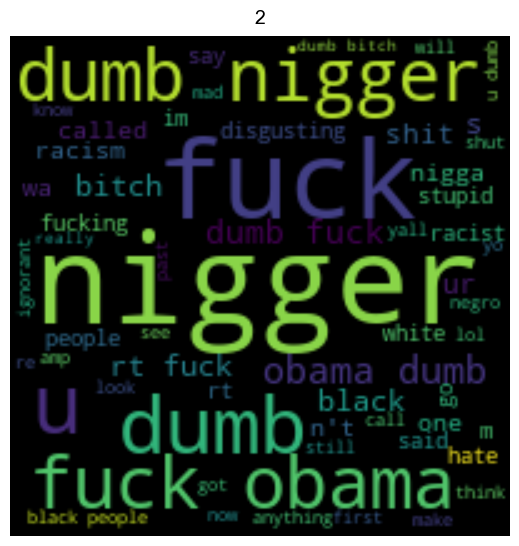

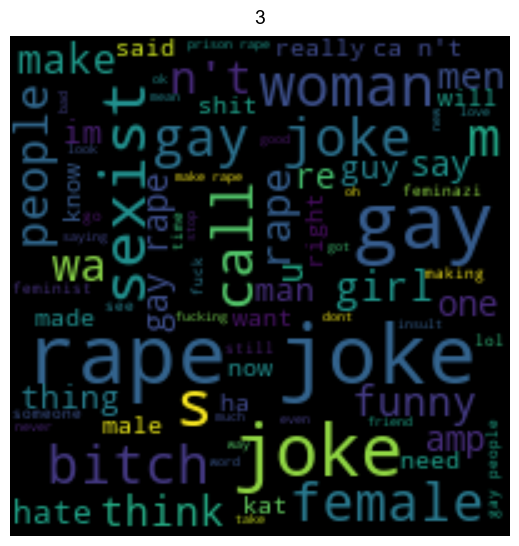

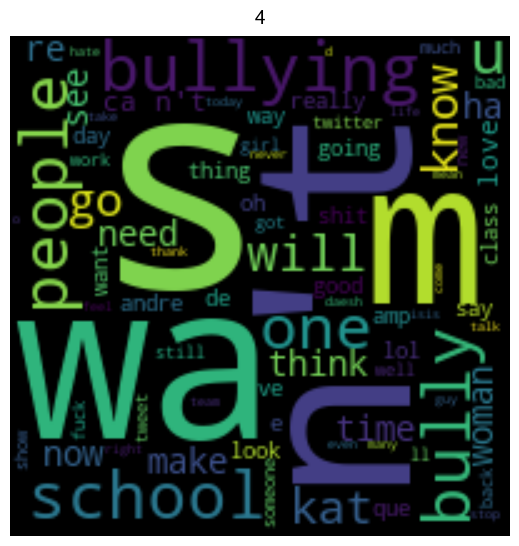

In [76]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
encodesentiment = LabelEncoder()

def generate_wordcloud(text, title):
    wordcloud = WordCloud(width = 200, height = 200,
                background_color ='black',
                min_font_size = 5).generate(text)

    plt.figure(figsize=(5, 5), facecolor=None)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.tight_layout(pad=0)

    plt.title(title, fontdict={'size': 14, 'color': 'black',
                                      'verticalalignment': 'bottom'})
    plt.show()

def process_text(newdataframe):
    newdataframe.bullyingtype = encodesentiment.fit_transform(newdataframe.bullyingtype)
    sns.set(style="white", context="talk")

def generate_wordcloud_for_label(newdataframe, label):
    string = " ".join(newdataframe[newdataframe.bullyingtype == label].PreProcessedText.values)
    generate_wordcloud(string, encodesentiment.classes_[label])
    del string

# Call functions
process_text(newdataframe)

generate_wordcloud_for_label(newdataframe, 0)
generate_wordcloud_for_label(newdataframe, 1)
generate_wordcloud_for_label(newdataframe, 2)
generate_wordcloud_for_label(newdataframe, 3)
generate_wordcloud_for_label(newdataframe, 4)